In [62]:
import pylab as pl
%matplotlib inline
pl.rcParams['figure.figsize'] = 15, 10

In [81]:
import csv
import glob
from collections import defaultdict
import pandas as pd
import numpy as np
import itertools
import codecs
from os import path
import csv
import numpy as np


In [64]:
#From http://rosettacode.org/wiki/Set_consolidation#Python
def consolidate(sets):
    setlist = [set(s) for s in sets if s] # convert to mutable_set
    for i, s1 in enumerate(setlist):
        if s1:
            for s2 in setlist[i+1:]:
                intersection = s1.intersection(s2)
                if intersection:
                    s2.update(s1)
                    s1.clear()
                    s1 = s2
    return [frozenset(s) for s in setlist if s]

In [65]:

def load_paraphrase_groups():
    for filename in glob.glob("opinosis_split/*"):
        table = pd.read_csv(filename, delimiter='\t', header=None,  encoding = "ISO-8859-1")
        
        for col_num in range(1,table.shape[1]): #Skip column zero as that contains unsorted entrys
            pf_group = table.iloc[:,col_num].dropna().tolist()
            if len(pf_group)>0:
                yield pf_group


In [66]:
def postprocess(sentence):
    import re
    def replace_broken_hypen(first_half, second_half, sentence):
        pattern = r"(?<=%s),\s?(?=%s)" % (first_half, second_half)
        return re.sub(pattern, "-",sentence,flags=re.IGNORECASE)
    
    sentence=sentence.strip()
    sentence=re.sub(r"^\d\s(?! hour|out|block)","",sentence,flags=re.IGNORECASE) #remove starting numbers
    sentence=re.sub(r"^([\.\,\-\!\?\;\:\>]\s*)+","",sentence) #remove starting punctuation

    sentence=re.sub(r"(,\s?)+",", ",sentence) #remove repeated commas
    sentence =sentence.replace("&quot", "\"")
    sentence =sentence.replace("&amp", "\"")
   
    sentence =replace_broken_hypen("e", "ink", sentence)
    sentence =replace_broken_hypen("non", "smoking", sentence)
    sentence =replace_broken_hypen("on", "line", sentence)
    return sentence

In [68]:
pf_groups = list(load_paraphrase_groups())
pf_groups = [frozenset(map(postprocess, group)) for group in pf_groups]
pf_groups = consolidate(pf_groups)

In [100]:
pf_groups = [group for group in pf_groups if len(group)>2]

In [104]:
16*6+3*21

159

In [107]:
sum(pf_group_sizes)

521

In [102]:
len(pf_groups)

89

{3: 36,
 4: 20,
 5: 6,
 6: 8,
 7: 4,
 8: 4,
 9: 3,
 10: 1,
 11: 1,
 16: 1,
 17: 1,
 24: 1,
 27: 1,
 30: 1,
 33: 1}


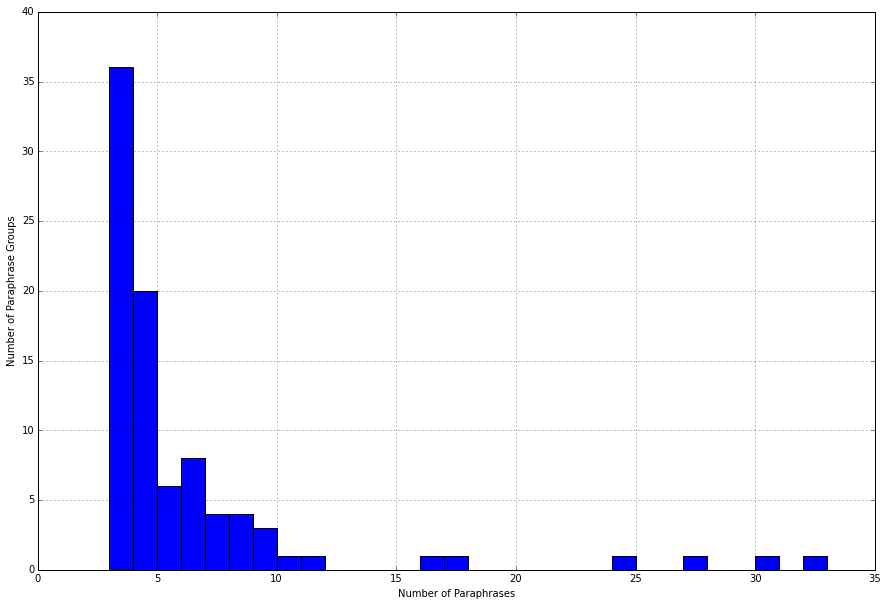

In [101]:
pf_group_sizes = pd.Series(list(map(len,pf_groups)))
pl.xlabel("Number of Paraphrases")
pl.ylabel("Number of Paraphrase Groups")
plt = pf_group_sizes.hist(bins=30, ax=pl.gca())
pf_group_sizes.groupby(by=lambda x:x)
from collections import Counter
from pprint import pprint
pprint(Counter(pf_group_sizes))

In [94]:
pf_groups.groupby(level=0).filter(lambda x: len(x)=3)

SyntaxError: lambda cannot contain assignment (<ipython-input-94-5a6720c291e8>, line 1)

In [73]:
def save(pf_groups, save_dir):
    from os.path import join as pathjoin
    import csv
    
    with open(pathjoin(save_dir,"phrases.txt"),"w") as phrases_fh:
        with open(pathjoin(save_dir,"phrase_groups.csv"),"w") as groups_fh:
            group_csv = csv.writer(groups_fh)
            group_csv.writerow(["phrase_index","paraphrase_group_index"])
            phrase_index = 0;
            for group_index, group in enumerate(pf_groups):
                for phrase in group:
                    phrases_fh.write(phrase)
                    phrases_fh.write("\n")
                    
                    group_csv.writerow([phrase_index,group_index])

                    phrase_index+=1
                

In [74]:
save(pf_groups, "prepared_corpora/opinosis/")

In [78]:
def load_MSRP(filename):
    with codecs.open(filename,'r', "utf-8" ) as fh:
        nlines = 0
        for line in fh.readlines():
            nlines+=1
            if nlines==1:
                continue
            isparaphrase, id1, id2, str1, str2 = line.split("\t") #the quality fielld is 1 for phraphrases and 0 for not
            yield(int(isparaphrase)==1, (int(id1),str1.strip()),(int(id2),str2.strip()))


def get_MSRP_paraphrase_groups(msrp):
    index_to_sentence = dict()
    
    pf_groups=[]
    for ispara, (id1, sent1), (id2,sent2) in msrp:
        if ispara:
            index_to_sentence[id1] = sent1
            index_to_sentence[id2] = sent2
            pf_groups.append({id1,id2})
            
    pf_groups = consolidate(pf_groups)
    return [{index_to_sentence[sent_id] for sent_id in grp} for grp in pf_groups if len(grp)>2]

In [82]:
corp_gen = itertools.chain(
        load_MSRP("base_corpora/MSRP/msr_paraphrase_test.txt"),
        load_MSRP("base_corpora/MSRP/msr_paraphrase_train.txt")
)


msrp_groups = get_MSRP_paraphrase_groups(corp_gen)

In [84]:
save(msrp_groups, "prepared_corpora/msrp/")

Counter({3: 240, 4: 31, 5: 3})

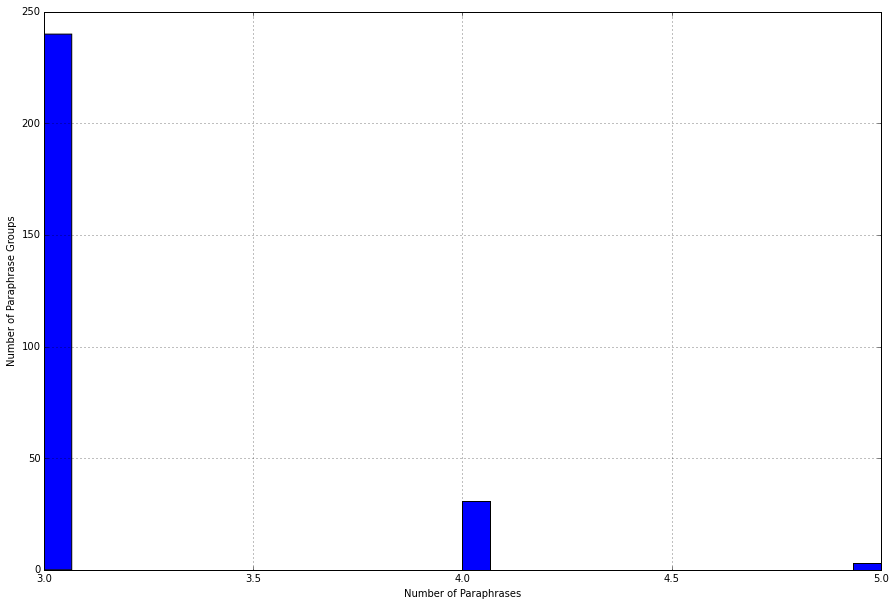

In [96]:
msrp_pf_group_sizes = pd.Series(list(map(len,msrp_groups)))
pl.xlabel("Number of Paraphrases")
pl.ylabel("Number of Paraphrase Groups")
plt = msrp_pf_group_sizes.hist(bins=30, ax=pl.gca())
msrp_pf_group_sizes.groupby(by=lambda x:x)
from collections import Counter
Counter(msrp_pf_group_sizes)

In [90]:
from collections import Counter
Counter(msrp_pf_group_sizes)

Counter({3: 240, 4: 31, 5: 3})

In [91]:
pf_group_sizes.sum()

859

In [92]:
3*240+4*31+15

859

In [ ]:
g